# `shapely`对矢量数据的处理(1) 构造, 度量与拓补

In [1]:
import shapely; 
import shapely.geometry as shplgeo, shapely.ops as shplops; 

## `shapely.geometry`中的几何图形对象

### 单点(`Point`)和多点(`MultiPoint`)对象
构造方法
* 单点或多点对象通过声明每个点在**直角坐标系**中的坐标得到
    * 因此, 如果需要使用`shapely`处理GIS中的矢量数据, 需要**为数据指定适当的投影坐标系**
* 多点对象可通过不同的单点对象取并集(联合叠置分析)得到

POINT (1 0) POINT (0 1) POINT (0 0)
MULTIPOINT (1 0, 0 1, 0 0)


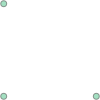

In [2]:
#定义三角形ΔABC的三个顶点, 显然C是直角顶点
vertex_coord = ((1, 0), (0, 1), (0, 0)); 
A, B, C = tuple(shplgeo.Point(x, y) for x, y in vertex_coord); 
verteces = shplgeo.multipoint.MultiPoint(vertex_coord); 
print(A, B, C); print(verteces); 
verteces

多点对象的有序性
* 打乱多点对象中点的先后顺序构造新的多点对象后: 
    * 新对象与原对象使用`==`进行比较将返回`False`, 
    * 但如调用`equals`方法, 则返回`True`. 

In [3]:
print(A.union(B).union(C) == verteces); 
print(A.union(C).union(B) == verteces); 
print(A.union(C).union(B).equals(verteces)); 

False
False
True


### 折线(`Linestring`)和闭合折线(`LinearRing`)对象
构造方法
* 通过声明其**顺次连接**的每个点的坐标得到
* 根据多点对象转换得到
* 如果要求`LineString`折线闭合, 需要将首个点的信息复制并添加至坐标序列尾部

In [4]:
multiSegABC = shplgeo.LineString(verteces); #此时得到的折线ABC仅包含线段AB和BC
multiSegACB = shplgeo.LineString(
    tuple(verteces[idx] for idx in (0, 2, 1))
);  #此时得到的折线ACB仅包含线段AC和CB, 因为是按照A, C, B的顺序取顶点组成tuple
closedSegABC = shplgeo.LinearRing(verteces); 
print(multiSegABC, multiSegACB, closedSegABC, sep='\n'); 

LINESTRING (1 0, 0 1, 0 0)
LINESTRING (1 0, 0 0, 0 1)
LINEARRING (1 0, 0 1, 0 0, 1 0)


### 多边形(`polygon`)对象
构造方法
* 需要指定多边形的外边界, 若多边形内部存在孔洞, 还需要指定内边界
* 声明其内, 外边界**顺次连接**的每个点的坐标得到; 
* 根据多点, 折线对象转换得到; 

多边形的有效性
* 有效的条件: 
    * 外边界和内边界(如果指定)的顶点数量不少于3个; 
    * 任何一条边**除端点外的部分**, 不得与其他边存在公共点; 
    * 多边形除顶点和边以外的部分, 处在同一个连通分支内
* 多边形无效时, 部分属性或方法无法正常调用. 
* 多边形有效与否的状态值可通过`is_valid`属性获取; 
* 将无效多边形转化为有效多边形的方式, 主要调用`buffer`属性, 并设置缓冲长度为0

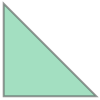

In [5]:
triangleABC = shplgeo.Polygon(verteces); 
triangleACB = shplgeo.Polygon(multiSegACB); 
triangleABC

多边形端点的有序性
* 与多点, 折线对象类似, 多边形对象的顶点也是有序的
    * 但调换多边形的方向, 所得的新多边形面积并不会变号, \
      因为`polygon`对象的`area`属性, 计算的是无向多边形的面积

In [6]:
print(triangleABC == triangleACB, triangleABC.equals(triangleACB))
print(triangleABC.area, triangleACB.area)

False True
0.5 0.5


## `shapely.geometry`几何对象的度量特征

### 位置信息
|方法名称|功能|备注|
|:-|:-:|:-|
|`coords`|提取几何图形的每个<br>组件的坐标信息||
|`centroid`|计算几何中心点||
|`bounds`|计算图形各坐标<br>分量的最小(大)值||
|`envelope`|计算外接矩形<br>或外接立方体|外接矩形(立方体)的边(棱, 面)<br>平行于坐标轴或坐标平面, <br>可用于提高空间查询效率|
|`minimum_rotated`<br>`_rectangle`|计算最小外接<br>矩形(立方体)|长宽(高)比例和长边方向<br>可大致反映图形的形状和朝向|
|`convex_hull`|计算最小外接凸<br>多边形或凸多面体|衡量多边形边缘的复杂度|

In [7]:
geomt = [verteces, multiSegABC, multiSegACB, triangleABC]; 

In [8]:
geomt_Cent = [shp.centroid for shp in geomt]; 
[print(shp.coords.xy) for shp in geomt_Cent]; 

(array('d', [0.3333333333333333]), array('d', [0.3333333333333333]))
(array('d', [0.29289321881345254]), array('d', [0.5]))
(array('d', [0.25]), array('d', [0.25]))
(array('d', [0.3333333333333333]), array('d', [0.3333333333333333]))


In [9]:
#分别构造上述几何图形的外接矩形, 最小外接矩形, 最小外接凸多边形
geomt_Envl = [shp.envelope for shp in geomt]; 
geomt_RotEnvl = [shp.minimum_rotated_rectangle for shp in geomt]; 
geomt_Convex = [shp.convex_hull for shp in geomt]; 

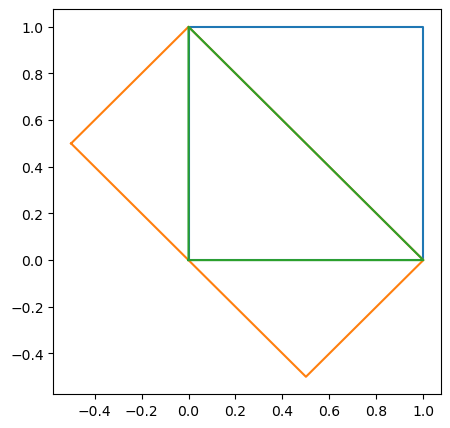

In [10]:
#绘图比较三种外接多边形的范围
import matplotlib.pyplot as plt; 
plt.subplots(figsize=(5, 5)); 
for polygon in list(zip(geomt_Envl, geomt_RotEnvl, geomt_Convex))[0]: 
    x, y = polygon.boundary.xy; 
    plt.plot(x, y); 
plt.show(); 

### 形状信息
|方法名称|功能|备注|
|:-|:-:|:-|
|`is_closed`|判断折线是否闭合|终点与起点重合|
|`is_ring`|判断折线是否成环|终点与起点重合, **同时**任何<br>一条边除端点外的部分, 不得<br>与其他边存在公共点|
|`booundary`|计算折线的起终点或<br>多边形的所有边界|对于`Point`, `MultiPoint`<br>或`LinearRing`对象, <br>该方法的返回值为不包含<br>任何要素的几何对象|
|`exterior`|返回多边形的外部边界||
|`interiors`|返回多边形所有<br>孔洞边界的列表||

In [11]:
cmplx_Polygon = geomt_Envl[0].union(geomt_RotEnvl[0]); 
cmplx_Polygon = shplgeo.Polygon(cmplx_Polygon.boundary, 
    holes=[triangleABC.boundary]); 

In [12]:
cmplx_bnd = cmplx_Polygon.boundary; 
cmplx_ext = cmplx_Polygon.exterior; 
cmplx_int = cmplx_Polygon.interiors[0]; 
print(cmplx_bnd, cmplx_ext, cmplx_int, sep='\n'); 

MULTILINESTRING ((0 0.9999999999999998, 0 1, 1 1, 1 0, 0.9999999999999998 0, 0.4999999999999999 -0.4999999999999999, 0 0, -0.4999999999999999 0.4999999999999999, 0 0.9999999999999998), (1 0, 0 1, 0 0, 1 0))
LINEARRING (0 0.9999999999999998, 0 1, 1 1, 1 0, 0.9999999999999998 0, 0.4999999999999999 -0.4999999999999999, 0 0, -0.4999999999999999 0.4999999999999999, 0 0.9999999999999998)
LINEARRING (1 0, 0 1, 0 0, 1 0)


### 大小信息
|方法名称|功能|备注|
|:-|:-:|:-|
|`length`|计算折线或多边形<br>边界的全长|对于`Point`或`MultiPoint`对象, <br>该方法的返回值始终为0. |
|`area`|计算多边形的面积|对于`Point`, `MultiPoint`, <br>`LineString`或`LinearRing`对象, <br>该方法的返回值始终为0. |

In [13]:
import decimal as deci; from decimal import Decimal; 
deci.setcontext(deci.Context(prec=6, rounding=deci.ROUND_HALF_EVEN)); 
[print(Decimal(str(shp.length)).fma(1, 0), 
    Decimal(str(shp.area)).fma(1, 0), 
    sep='\t') \
    for shp in (A, multiSegABC, triangleABC)];

0.0	0.0
2.41421	0.0
3.41421	0.5


In [14]:
shplgeo.LineString([[1, 0], [0, 1]]).project(C)

0.7071067811865476

### 距离信息
|方法名称|功能|备注|
|:-|:-:|:-|
|`distance`|计算几何图形中<br>各点到另一图形<br>距离的最小值||
|`shapely.ops`<br>`.nearest_point`|计算两个几何图形间, <br>距离最小的一组点|E返回的点的顺序与其<br>所在的几何图形在函数<br>调用时的顺序一致|
|`hausdorff_distance`|计算几何图形中<br>各点到另一图形<br>距离的最大值||


* 点到图形距离被定义为到目标图形中所有点Euclidean距离中的最小值
* 如综合使用缓冲区分析, 叠置分析, 以及邻近点分析功能, 可查询特定路线沿途的POI分布及其距离

In [15]:
#计算三角形斜边上的高, 及其垂足
edge_AB = shplgeo.LineString([A, B]); 
hgt_AB = C.distance(edge_AB); 
foot_hgt_AB = shplops.nearest_points(C, edge_AB)[1]; 
print(hgt_AB, foot_hgt_AB); 

0.7071067811865476 POINT (0.5 0.5)


## `shapely.geometry`几何对象的拓补关系
|方法名称|功能|备注|
|:-|:-:|:-|
|`shp1.disjoint(shp2)`|相离关系|`shp2`与`shp1`没有任何公共部分|
|`shp1.intersects(shp2)`|相交关系|`disjoint`关系的反义: <br>`shp2`与`shp1`有公共部分|
|`shp1.touches(shp2)`|邻接关系|`intersects`的特殊情况: <br>`shp2`与`shp1`有公共部分, <br>且全部位于二者的边界内|
|`shp1.crosses(shp2)`|相交关系|`intersects`的特殊情况: <br>`shp2`与`shp1`有公共部分, 但不与`shp1`<br>或`shp2`重合, 其维数为二者中较大者减一|
|`shp1.overlaps(shp2)`|相交关系|`intersects`的特殊情况: <br>`shp2`与`shp1`有公共部分, 但不与`shp1`<br>或`shp2`重合, 且三者的维数均相同|
|`shp1.covers(shp2)`<br>`shp2.covered_by(shp1)`|包含关系|`intersects`的特殊情况: <br>`shp2`的所有点全部位于`shp1`的内部或边界|
|`shp1.contains(shp2)`<br>`shp2.within(shp1)`|包含关系|`covers` / `covered_by`的特殊情况: <br>`intersects`的特殊情况: <br>`shp2`的所有点全部位于`shp1`的内部或边界, <br>且`shp2`的内部点部分位于`shp1`的内部|
|`shp1.equals(shp2)`|相等关系|`contains` / `within`的特殊情况: <br>`shp2`与`shp1`完全重合, <br>对图形中各部分顺序和组合方式不作要求|
|`shp1.equals_exact(shp2)`|相等关系|`equals`的特殊情况: <br>`shp2`与`shp1`完全重合, <br>且图形中各部分顺序和组合方式一致|

In [16]:
#分析不同图形之间的拓补关系
ls_topo_rel = ['disjoint', 'intersects', 'touches\t', 'crosses\t', 'overlaps', \
    'covers\t', 'contains', 'equals\t']; 
for mem_topo_rel in ls_topo_rel: 
    topo_rel = mem_topo_rel.strip(); 
    print(
        mem_topo_rel, 
        eval(f'C.{topo_rel}(edge_AB)'), 
        eval(f'C.{topo_rel}(triangleABC)'), 
        eval(f'multiSegABC.{topo_rel}(geomt_RotEnvl[0])'), 
        eval(f'geomt_RotEnvl[0].{topo_rel}(triangleABC)'), 
        eval(f'geomt_Envl[0].{topo_rel}(triangleABC)'), 
        eval(f'geomt_Convex[0].{topo_rel}(triangleABC)'), 
        sep='\t'
    )

disjoint	True	False	False	False	False	False
intersects	False	True	True	True	True	True
touches		False	True	False	False	False	False
crosses		False	False	True	False	False	False
overlaps	False	False	False	True	False	False
covers		False	False	False	False	True	True
contains	False	False	False	False	True	True
equals		False	False	False	False	False	True
